In [1]:
import numpy as np
import h5py
import petl as etl
import sys
sys.path.insert(0, '../..')
import allel; print('allel', allel.__version__)

allel 0.20.3


In [2]:
callset = h5py.File('/data/coluzzi/ag1000g/data/phase1/release/AR3/variation/main/hdf5/ag1000g.phase1.ar3.pass.h5',
                    mode='r')
callset

<HDF5 file "ag1000g.phase1.ar3.pass.h5" (mode r)>

In [28]:
chrom = '3L'

In [29]:
tbl_samples = (etl
    .fromtsv('/data/coluzzi/ag1000g/data/phase1/release/AR3/samples/samples.meta.txt')
    .convert('index', int)
)
tbl_samples

index,ox_code,src_code,sra_sample_accession,population,country,region,contributor,contact,year,m_s,sex,n_sequences,mean_coverage,latitude,longitude
0,AB0085-C,BF2-4,ERS223996,BFS,Burkina Faso,Pala,Austin Burt,Sam O'Loughlin,2012,S,F,89905852,28.01,11.15,-4.235
1,AB0087-C,BF3-3,ERS224013,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,116706234,36.76,11.233,-4.472
2,AB0088-C,BF3-5,ERS223991,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,112090460,23.3,11.233,-4.472
3,AB0089-C,BF3-8,ERS224031,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,145350454,41.36,11.233,-4.472
4,AB0090-C,BF3-10,ERS223936,BFM,Burkina Faso,Bana,Austin Burt,Sam O'Loughlin,2012,M,F,105012254,34.64,11.233,-4.472


In [41]:
pop1 = 'BFS'
pop2 = 'BFM'

In [42]:
pop1_idx = tbl_samples.eq('population', pop1).values('index').list()
pop2_idx = tbl_samples.eq('population', pop2).values('index').list()

In [43]:
genotypes = allel.GenotypeChunkedArray(callset[chrom]['calldata/genotype'])
genotypes

,0,1,2,3,4,...,760,761,762,763,764
0,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
1,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
2,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
3,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0
4,0/0,0/0,0/0,0/0,0/0,...,0/0,0/0,0/0,0/0,0/0


In [44]:
acs = genotypes.count_alleles_subpops({pop1: pop1_idx, pop2: pop2_idx}, max_allele=3)
acs

BFM,BFS
[138 0 0 0],[162 0 0 0]
[138 0 0 0],[161 1 0 0]
[138 0 0 0],[162 0 0 0]
[137 1 0 0],[161 1 0 0]
[135 3 0 0],[161 1 0 0]


In [45]:
ac1, ac2 = acs[pop1], acs[pop2]

In [46]:
ac = ac1 + ac2
loc_seg = ac.is_segregating()
ac1_seg = ac1.compress(loc_seg)
ac2_seg = ac2.compress(loc_seg)

In [47]:
size = 5000

In [48]:
td1 = allel.stats.moving_tajima_d(ac1_seg, size=size)
td2 = allel.stats.moving_tajima_d(ac2_seg, size=size)
dtd = allel.stats.moving_delta_tajima_d(ac1_seg, ac2_seg, size=size)

In [49]:
pos = callset[chrom]['variants/POS'][:]
pos_seg = pos.compress(loc_seg)

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

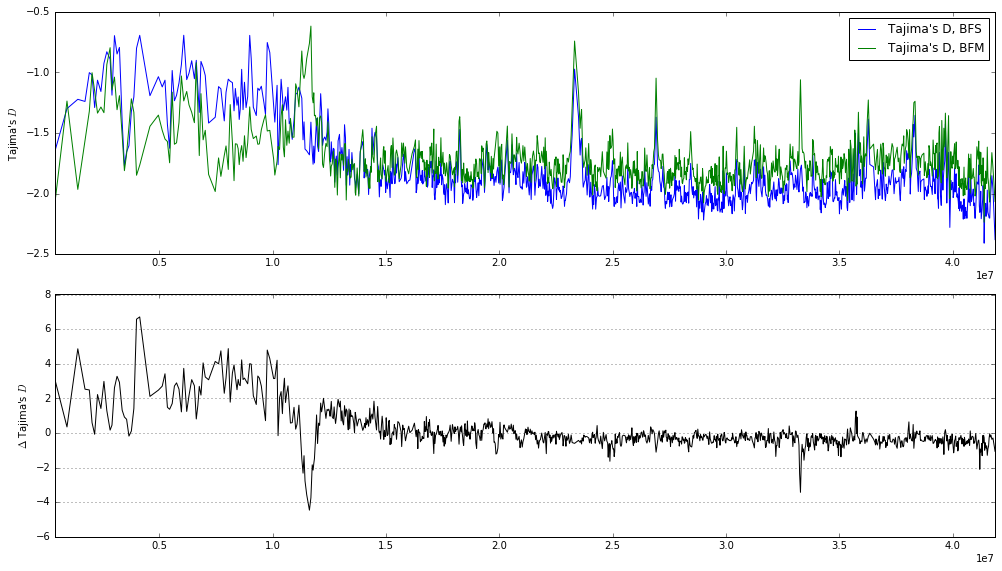

In [53]:
x = allel.stats.moving_mean(pos_seg, size=size)
fig = plt.figure(figsize=(14, 8))

ax = fig.add_subplot(2, 1, 1)
ax.plot(x, td1, label="Tajima's D, %s" % pop1)
ax.plot(x, td2, label="Tajima's D, %s" % pop2)
ax.autoscale(axis='x', tight=True)
ax.legend()
ax.set_ylabel("Tajima's $D$")

ax = fig.add_subplot(2, 1, 2)
ax.plot(x, dtd, label="Delta Tajima's D", color='k')
ax.autoscale(axis='x', tight=True);
ax.set_ylabel("$\Delta$ Tajima's $D$")
ax.grid(axis='y')

fig.tight_layout()

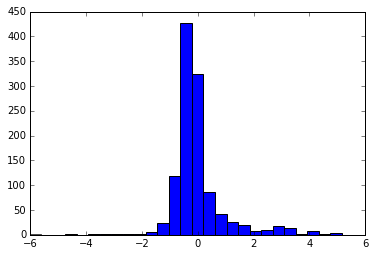

In [59]:
plt.hist(dtd, bins=np.linspace(-6, 6, 30))
plt.xlim(-6, 6);

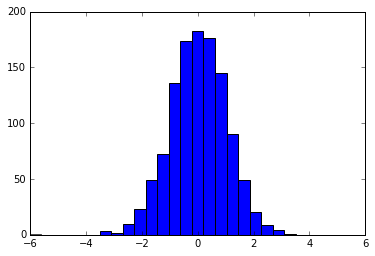

In [60]:
x = np.random.normal(loc=np.mean(dtd), scale=np.std(dtd), size=dtd.size)
plt.hist(x, bins=np.linspace(-6, 6, 30))
plt.xlim(-6, 6);

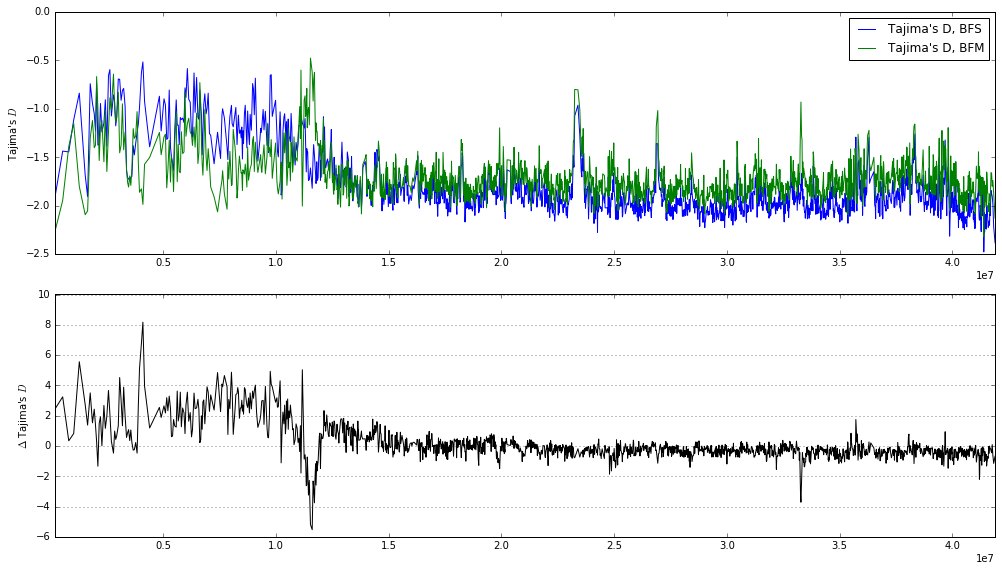

In [61]:
td1 = allel.stats.moving_tajima_d(ac1, size=size)
td2 = allel.stats.moving_tajima_d(ac2, size=size)
dtd = allel.stats.moving_delta_tajima_d(ac1, ac2, size=size)

x = allel.stats.moving_mean(pos, size=size)
fig = plt.figure(figsize=(14, 8))

ax = fig.add_subplot(2, 1, 1)
ax.plot(x, td1, label="Tajima's D, %s" % pop1)
ax.plot(x, td2, label="Tajima's D, %s" % pop2)
ax.autoscale(axis='x', tight=True)
ax.legend()
ax.set_ylabel("Tajima's $D$")

ax = fig.add_subplot(2, 1, 2)
ax.plot(x, dtd, label="Delta Tajima's D", color='k')
ax.autoscale(axis='x', tight=True);
ax.set_ylabel("$\Delta$ Tajima's $D$")
ax.grid(axis='y')

fig.tight_layout()